In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [2]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import matplotlib
import kabuki
from matplotlib import pyplot as plt
import ipyparallel
from ipyparallel import parallel
import hddm
import os

%matplotlib inline
np.set_printoptions(suppress = True)

/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/user/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [51]:
os.chdir("/Users/user/Desktop/Experiments/Nick/AttentionSaccade")
sublist = [1,2,3,4,5,6,7,8,9]

datafname = os.path.join(os.getcwd(), 'AttentionSaccade_BehaviouralData_All.csv')
data = pd.read_csv(datafname, sep = ',', index_col = False) #read in collated data
data = data.drop(data.columns[0], axis = 1) #drop unnamed, random column that has appeared in the data
attention = data.loc[data['task']==1]
saccade   = data.loc[data['task']==2]
attention.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

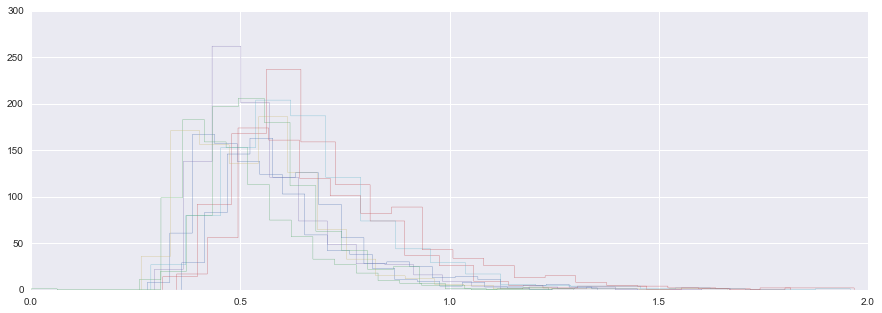

In [56]:
plt.rcParams['figure.figsize'] = (15,5)
for i, subject in attention.groupby('subject'):
    subject.time.hist(bins = 20, histtype = 'step')

In [43]:
attention = attention[['subject', 'time', 'corr', 'validity']] #select dataframe down to just these variables
attention = attention.rename(columns={'time':'rt', "corr":'response','subject':'subj_idx'}) #rename for use with hddm package
attention = attention[np.isnan(attention['rt'])==False] #remove trials with no response

attval = attention[attention['validity']==1]
attinv = attention[attention['validity']==0]

#rename colding of validity to string instead of number
attention.loc[attention.validity==1, 'validity'] = 'valid'
attention.loc[attention.validity==0, 'validity'] = 'invalid'
print attval.shape, attinv.shape

#attention.shape
#attention = attention[attention['rt']<0.05]
#np.where(np.isnan(attention['rt'])) #check for missing data

(6891, 4) (1721, 4)


In [44]:
#drift diffusion model on attention task data
model = hddm.HDDM(data= attention, p_outlier=0.05, bias = True,
                 depends_on = {'a':'validity', 'v':'validity', 't':'validity', 'z':'validity'}) #depends_on : model parameters estimated separately for validity conditions (so we can look at validity effect on model parameters)
model.find_starting_values()
model.sample(5000, burn=500)

 [-----------------100%-----------------] 5000 of 5000 complete in 408.6 sec

In [46]:
# a, v, t, z parameters for each participant, and the group (mean + stds)
# a = decision threshold
# v = drift rate
# t = non-decision time parameter
# z = prepotent response bias
stats = model.gen_stats()
stats[stats.index.isin(['a(valid)','a(invalid)','v(valid)','v(invalid)','t(valid)','t(invalid)','z(valid)','z(invalid)'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a(invalid),1.16097,0.0449423,1.07348,1.13174,1.16045,1.18919,1.25351,0.000871571
a(valid),1.24471,0.0424981,1.15865,1.21791,1.24405,1.27113,1.33244,0.000721807
v(invalid),1.26325,0.203803,0.85359,1.13493,1.26356,1.39496,1.65878,0.0034626
v(valid),2.09363,0.197216,1.69837,1.97175,2.09332,2.2205,2.49297,0.00354715
t(invalid),0.423296,0.021957,0.380373,0.409224,0.423427,0.436969,0.467597,0.000342743
t(valid),0.32249,0.0214581,0.281797,0.308329,0.321893,0.336338,0.365627,0.000320299
z(invalid),0.505436,0.0158374,0.474301,0.495061,0.505322,0.516065,0.536412,0.000441392
z(valid),0.461673,0.0140641,0.434324,0.452507,0.461407,0.471141,0.489646,0.000409994


In [23]:
# model valid and invalid trials separately
modelvalid = hddm.HDDM(data = attval, p_outlier=0.05, bias = True)
modelvalid.find_starting_values()
modelvalid.sample(2000, burn = 20)

modelinv = hddm.HDDM(data=attinv, p_outlier=0.05, bias = True)
modelinv.find_starting_values()
modelinv.sample(2000, burn = 20)

#output stats for the independent models
stats_valid = modelvalid.gen_stats()
stats_valid[stats_valid.index.isin(['a', 'a_std', 'v','v_std', 't', 't_std', 'z', 'z_std'])] #only show group parameters
stats_invalid = modelinv.gen_stats()
stats_invalid[stats_invalid.index.isin(['a', 'a_std', 'v','v_std', 't', 't_std', 'z', 'z_std'])]


/Users/user/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/user/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 116.6 sec